In [51]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets #Sert pour le slider
from ipywidgets import interact,IntSlider



In [2]:
start="2020-01-01"
end="2023-12-01"

In [3]:
def clean_cols(df):

    df.columns = [c[0] for c in df.columns]
    return df

VIX=clean_cols(yf.download("^VIX",start, end))
sp500_v=clean_cols(yf.download("^GSPC",start, end))
sp500_v.head()



C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\1093527190.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX=clean_cols(yf.download("^VIX",start, end))
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\1093527190.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_v=clean_cols(yf.download("^GSPC",start, end))
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


# I. Observation Générales

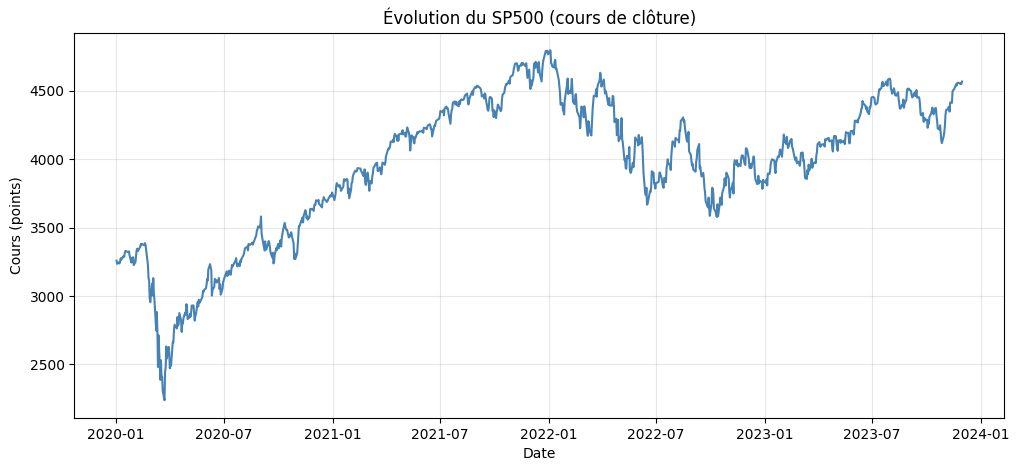

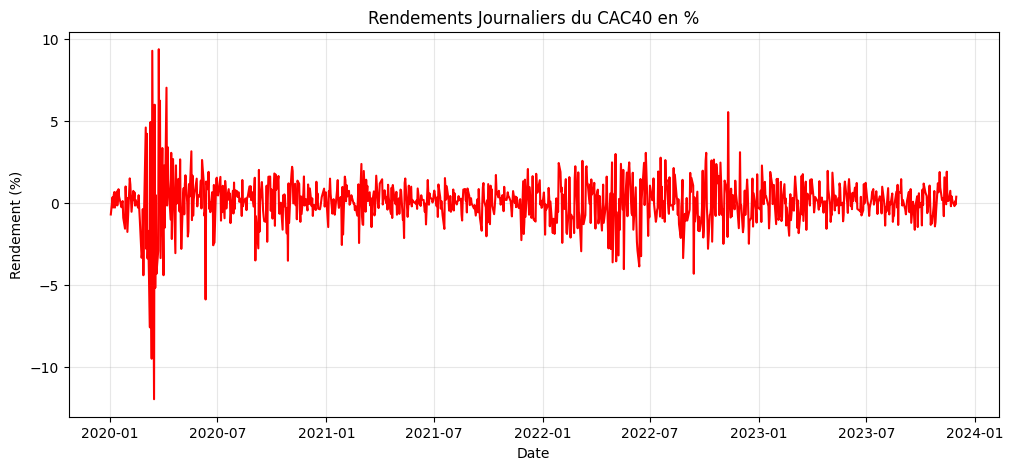

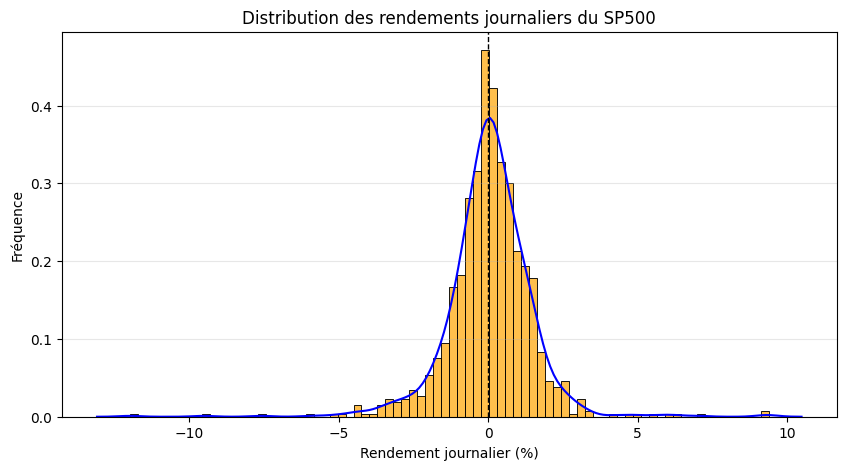

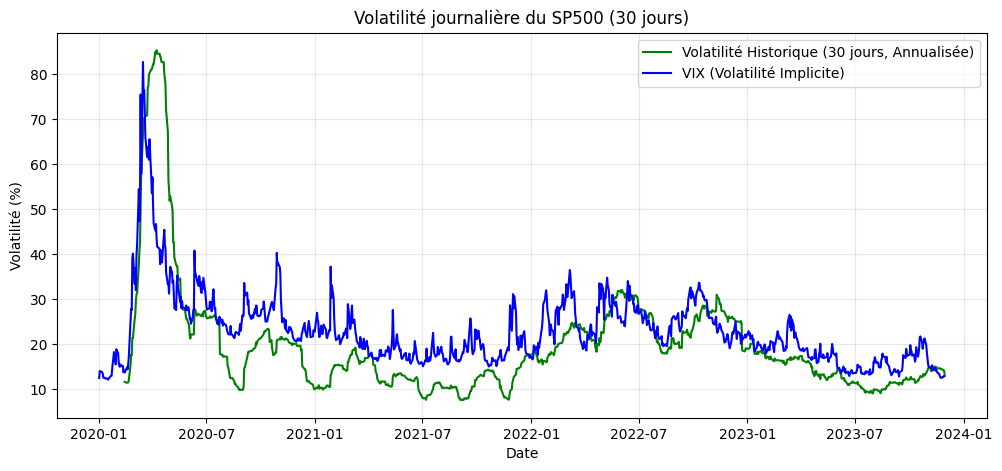

In [4]:
plt.figure(figsize=(12,5))
plt.plot(sp500_v["Close"], color="steelblue")
plt.title("Évolution du SP500 (cours de clôture)")
plt.xlabel("Date")
plt.ylabel("Cours (points)")
plt.grid(True, alpha=0.3)
plt.show()


#Visualisations Rendements


plt.figure(figsize=(12,5))
sp500_v["rendements"]= (sp500_v["Close"]-sp500_v["Close"].shift(1))/sp500_v["Close"].shift(1)*100
sp500_v=sp500_v.dropna()
plt.plot(sp500_v["rendements"],color="red")
plt.title("Rendements Journaliers du CAC40 en %")
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.grid(True, alpha=0.3)
plt.show()

#Histogramme avec KDE
plt.figure(figsize=(10,5))
sns.histplot(sp500_v["rendements"], bins=80, color="orange", edgecolor="black", alpha=0.7,stat="density")
sns.kdeplot(sp500_v["rendements"],color="blue",label="Densité KDE")
plt.title("Distribution des rendements journaliers du SP500")
plt.xlabel("Rendement journalier (%)")
plt.ylabel("Fréquence")
plt.grid(axis="y", alpha=0.3)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

#Volatilité

sp500_v["vol_30j"]=sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252)   #On a 252 jours de bourse par an et le VIX est annualisé: On met à l'échelle
sp500_v=sp500_v.dropna()
plt.figure(figsize=(12,5))
plt.plot(sp500_v["vol_30j"], color="green", label="Volatilité Historique (30 jours, Annualisée)")
plt.title("Volatilité journalière du SP500 (30 jours)")
plt.xlabel("Date")
plt.ylabel("Volatilité (%)")
plt.grid(True, alpha=0.3)

#VIX
plt.plot(VIX["Close"], color="blue", label="VIX (Volatilité Implicite)")

plt.legend()


# II. Analyse du SP500 (sous jacent du VIX)

In [5]:
#On récupère les infos sur le sp500 depuis un datahub
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
sp500 = pd.read_csv(url)
sp500 = sp500.drop(columns=["CIK", "Founded", "Date added", "Headquarters Location"])  #On supprime les colonnes inutiles
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [6]:
#On calcule le poids des entreprises manuellement

def get_marketcap(ticker):
  try:

      #On a 2/3 tickers qui sont différents entre le deux données, on corrige ça:
      if(ticker=="BRK.B"):
        ticker="BRK-B"
      if(ticker=="BF.B"):
        ticker="BF-B"

      info = yf.Ticker(ticker).info
      mc = info.get("marketCap", None)



      if mc is None:
          print(f"Pas de data pour {ticker}")
      return mc

  except Exception as e:
      print(f"Erreur sur {ticker}: {e}")
      return None

sp500["MarketCap"] = sp500["Symbol"].apply(get_marketcap)
total_marketcap = sp500["MarketCap"].sum()
sp500["Poids (%)"] = (sp500["MarketCap"] / total_marketcap) * 100
sp500 = sp500.sort_values("Poids (%)", ascending=False) #On trie pour faire joli

sp500.head()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}


Pas de data pour WBA


,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.441137e+12,6.747837
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",4.137204e+12,6.286043
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.891261e+12,5.912359
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.888217e+12,5.907734
316,MSFT,Microsoft,Information Technology,Systems Software,3.591409e+12,5.456765


On a une erreur 404 pour WBA: tant pis! ça représente uniquement 0.2% du poids environ. Le manque de cette info ne nuira donc pas à notre analyse

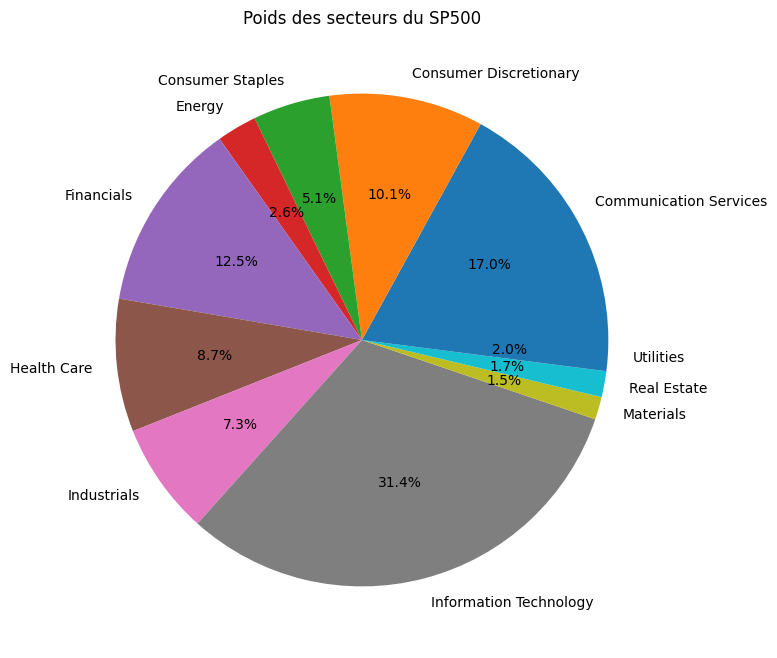

In [7]:
#Camembert Poids/Secteur
poids_secteurs=sp500.groupby("GICS Sector")["Poids (%)"].sum()
plt.figure(figsize=(8,8))
plt.pie(poids_secteurs, labels=poids_secteurs.index,autopct="%1.1f%%")
plt.title("Poids des secteurs du SP500")
plt.show()

Les secteurs principaux sont: La tech, les services telecom/medias, la finance, l'industrie, la santé et "consumers discretionary qu'on va analyser plus tard.


Ces domaines dépendent de:

-L'énergie (mix électrique USA: petrole/gaz/charbon/nucléaire)
- Les matières premières (Métaux/Métaux précieux)
- Les taux directeurs (FED)
- La bonne santé de l'économie américaine car en plus d'être affectés par l'économie, ces domaines dépendent des éventuelles subventions (dur à déterminer)



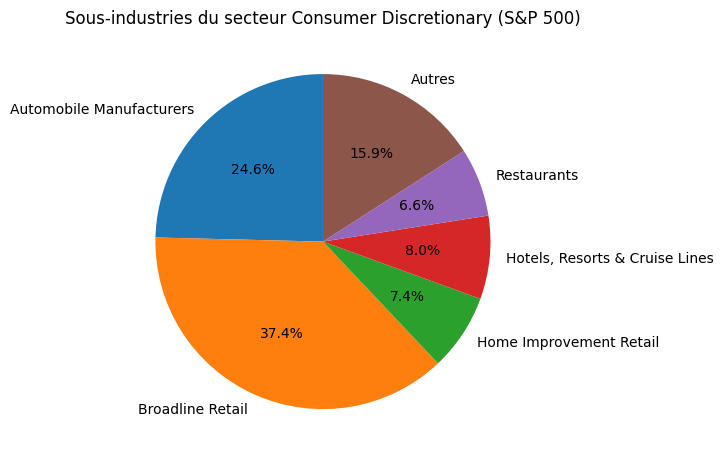

In [8]:
consumer_disc = sp500[sp500["GICS Sector"] == "Consumer Discretionary"]
poids_secteurs_consumer_disc = consumer_disc.groupby("GICS Sub-Industry")["Poids (%)"].sum()

# Regrouper les sous-industries de moins de 0.5 % (par rapport au total) dans "Autres" pour avoir un camembert moins chargé
poids = poids_secteurs_consumer_disc.copy()
autres = poids[poids < 0.5].sum()
poids = poids[poids >= 0.5]
poids["Autres"] = autres

# Camembert plus lisible
plt.figure(figsize=(7,7))
plt.pie(
    poids,
    labels=poids.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sous-industries du secteur Consumer Discretionary (S&P 500)")
plt.tight_layout()
plt.show()

On rajoute donc l'automobile qui rejoint l'industrie et les commerces (pas les supermarchés comme wallmart ect... car on est en dans des dépenses de confort)

In [9]:
#On prend aussi le top 10 du SP500:
top10 = sp500.sort_values("Poids (%)", ascending=False).head(10)
top10

,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.441137e+12,6.747837
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",4.137204e+12,6.286043
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.891261e+12,5.912359
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.888217e+12,5.907734
316,MSFT,Microsoft,Information Technology,Systems Software,3.591409e+12,5.456765
22,AMZN,Amazon,Consumer Discretionary,Broadline Retail,2.453725e+12,3.728176
71,AVGO,Broadcom,Information Technology,Semiconductors,1.842856e+12,2.800024
310,META,Meta Platforms,Communication Services,Interactive Media & Services,1.697374e+12,2.578979
439,TSLA,"Tesla, Inc.",Consumer Discretionary,Automobile Manufacturers,1.513248e+12,2.299220
59,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,1.088030e+12,1.653147


# III Ajout de nouvelles données

In [10]:
# Métaux
cuivre = clean_cols(yf.download("HG=F", start,end))
aluminium = clean_cols(yf.download("ALI=F", start, end))
nickel = clean_cols(yf.download("JJN", start, end))       #ETF JNN (à défaut d'avoir la donnée brute)
zinc = clean_cols(yf.download("ZINC.L", start, end))    #ETF

# Métaux précieux
Or = clean_cols(yf.download("GC=F", start, end))  #Valeur refuge, elle est corrélée aux crises sur les marchés. On l'importe ici par soucis de présentation
argent = clean_cols(yf.download("SI=F", start, end))

# Énergie
petrole = clean_cols(yf.download("CL=F", start, end))
gaz = clean_cols(yf.download("NG=F", start, end))
uranium = clean_cols(yf.download("URA", start, end))       # ETF Global x Uranium (à défaut d'avoir la donnée brute)


C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\3861883418.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cuivre = clean_cols(yf.download("HG=F", start,end))
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\3861883418.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aluminium = clean_cols(yf.download("ALI=F", start, end))
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\3861883418.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nickel = clean_cols(yf.download("JJN", start, end))       #ETF JNN (à défaut d'avoir la donnée brute)
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\3861883418.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to T

In [11]:
#On vérifie si tout est bien chargé
datasets = {
    "cuivre": cuivre,
    "aluminium": aluminium,
    "nickel": nickel,
    "zinc": zinc,
    "or": Or,
    "argent": argent,
    "petrole": petrole,
    "gaz": gaz,
    "uranium": uranium

}

for nom, df in datasets.items():
    if df is None or df.empty:
        print(f"{nom} : vide ou non chargé")


In [12]:
def rdm(df):
    df["rendements"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
    return df.dropna(inplace=True)


# Application de la fonction à tous les datasets
for nom, df in datasets.items():
    rdm(df)

Or["rendements"].head()

Date
2020-01-03    1.620200
2020-01-06    1.097341
2020-01-07    0.357560
2020-01-08   -0.916149
2020-01-09   -0.365999
Name: rendements, dtype: float64

In [13]:
#Pour ce qui est de la santé économique américaine, nous prendrons les obligations sur 10 ans.

oblig_10ans = clean_cols(yf.download("^TNX", start, end))

C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\3509007495.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_10ans = clean_cols(yf.download("^TNX", start, end))
[*********************100%***********************]  1 of 1 completed


# IV Analyse de corrélation et features engineering

In [14]:
#On Rajoute la Moyenne mobile simple (SMA: Simple Moving Average) à ne pas confondre avec la vol_30j

def SMA(df, window):
    return df.rolling(window=window).mean()


#On rajoute également l'indice de force relative (RSI: Relative Strengh Index): il mesure la vitesse et l'amplitude des variations récente de prix, ce qui est utile pour savoir si on a une forte pression à la hausse ou baisse


def RSI(data, dt):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=dt).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=dt).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi




rsi=RSI(sp500_v["Volume"],14)   #Pour le moment on prend la valeur "standard" qui équivaut à 14 jours. Néanmoins, il serait peut être intéressant de prendre une échelle de temps plus courte pour refléter la "nervosité du marché". Nous optimiseront plus tard
sma=SMA(sp500_v["Volume"],14)   #Nous prendrons également une SMA à court terme (à la même fenêtre que la rsi pour une question de cohérence et également pour les raisons énoncées en haut)
#sma : rolling moyenne somme prix / n
#rsi : pression à la hausse ou à la baisse



On crée 13 valeurs manquantes car on calcule sur une fenêtre et on fait un rolling. L'optimal serait de faire toutes les transformations (rendements, vol_30j,rsi ect...) en même temps pour ne pas trop les accumuler. Néanmoins, par souci de présentation et de lisibilité, nous laisseront le notebook tel quel. Vu le grand nombre de données, la perte est négligeable.

# Il est temps de faire nos premières mesures de corrélations:

In [34]:
#On va faire des fonctions pour pouvoir avoir des matrices de corrélations avec un slider temporel
def ensure_data_range(start_year, end_year, df_dict):
    #On converti en timestamp les années en entrée (Timestamp car c'est la forme de notre index "Date")
    requested_start = pd.Timestamp(f"{start_year}-01-01")
    requested_end   = pd.Timestamp(f"{end_year}-12-31")

    #Pour chaque df:
    for name, df in df_dict.items():
        #On regarde si on a déjà téléchargé la data, sinon on le fait
        if requested_start < df.index.min() or requested_end > df.index.max():
            print(f"Téléchargement {name}…")
            df_new= clean_cols(
                yf.download(name, "2000-01-01", "2023-12-31")
            ).dropna()
            rdm(df_new)
            df_dict[name]=df_new
            

    return df_dict

def plot_corr(start_year, end_year, df_dict, rename_dict=None,title="Corrélation"):

    # On corrige si les dates ont été inversées
    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)


    df_concat = pd.concat(
        {i: j["Close"] for i, j in df_dict.items()},
        axis=1
    )
    #On prend la période demandée et on l'extrait de df_concat
    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"
    
    final_df = df_concat.loc[start:end].dropna()

    #On fait attention à avoir assez de données
    if len(final_df) < 30:
        print("Intervalle trop court.")
        return

    corr = final_df.corr()

    # Renommage des variables
    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')  # empêche les doublons de graphes
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()


    

#Même fonctions sur les rendements
def plot_corr_rdm(start_year, end_year, df_dict,rename_dict=None,title="Corrélation"):
    
 
    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)

    df_concat = pd.concat(
        {i: j["rendements"] for i, j in df_dict.items()},
        axis=1
    )

    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"
    
    final_df = df_concat.loc[start:end].dropna()

    if len(final_df) < 30:
        print("Intervalle trop court.")
        return

    corr = final_df.corr()

    
    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')  
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()



A) Sur le prix de fermeture

In [35]:
#Il est temps d'évaluer nos théories:

#Corrélations entre les matières premières et le VIX:    
commos = {
    "^VIX": VIX,
    "HG=F": cuivre,
    "ALI=F": aluminium,
    "JJN": nickel,
    "ZINC.L": zinc,
    "GC=F": Or,
    "SI=F": argent,
  
}

rename_commo = {
    "^VIX": "VIX",
    "HG=F": "Cuivre",
    "GC=F": "Or",
    "SI=F": "Argent",
    "ZINC.L":"ETF ZINC",
    "ALI=F":"Aluminium",
    "JJN":"ETF Nickel"
}

#Utilisation de widgets
interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Corrélation avec les Commodities (Close)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On voit des corrélations intéressantes, notamment avec le cuivre, l'argent, l'or et l'aluminium.

Argent et Or étants eux mêmes très reliés (pareil pour le cuivre et l'aluminium), on va simplifier en ne gardant que l'argent et le cuivre.

B) Sur les rendements

In [ ]:

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Corrélation avec les Commodities (Rendements)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On remarque que le prix de fermeture indique des corrélations intéressantes alors que le rendement en indique des quasi nulles: C'est tout à fait normal!

Le rendement qui représente les variations journalières est souvent chaotique, suivant une loi normale (voir visualisations en début de page). Ainsi, il n'est pas surprenant de ne rien trouver (ça serait trop beau :'( )

Néanmoins le prix (celui de cloture), bien que possédant une corrélation gonflée (due à une tendance commune puisqu'on est sur un marché global): mais ce n'est donc pas quelque chose à négligler. En plus, il contient de la donnée historique (présente plus ou moins dans la tête des investisseurs).

Néanmoins, cela va peut être biaiser le modèle. Nous corrigeront cela si nécessaire

# On fait de même avec l'énergie:

In [40]:
#Corrélations entre les matières premières et le VIX:
# Énergie

energies={
    "^VIX":VIX,
    "NG=F":gaz,
    "URA":uranium,
    "CL=F":petrole

}

rename_energies={
    "^VIX":"VIX",
    "NG=F":"Gaz",
    "URA":"ETF Uranium",
    "CL=F":"Petrole"

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Corrélation avec l'énergie (Close)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [ ]:
interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Corrélation avec l'énergie (Rendements)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On note un lien intéressant avec l'uranium, même dans les rendements!: Peut être parce que c'est un ETF sur l'industrie en elle même?

On le garde

In [43]:
#Corrélations entre les obligations et le VIX
rdm(oblig_10ans)

gouvernerment={
    "^VIX":VIX,
    "^TNX":oblig_10ans
    
}

rename_gouvernement={
    "^VIX":"VIX",
    "^TNX":"Obligations 10ans"

}




interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Close)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [44]:

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Rendements)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On tient un filon, mais c'est pas trop ça. Essayons de prendre une maturité plus faible pour avoir une idée de l'impact des décisions récentes:

Prenons les 3 month treasury bills

In [ ]:
oblig_3mois=clean_cols(yf.download("^IRX", start, end))
#Corrélations entre les obligations et le VIX
rdm(oblig_3mois)

gouvernerment={
    "^VIX":VIX,
    "^TNX":oblig_10ans,
    "^IRX":oblig_3mois
    
}

rename_gouvernement={
    "^VIX":"VIX",
    "^TNX":"Obligations 10ans",
    "^IRX":"Obligations 3mois"

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Close)")
)

C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\48782524.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_3mois=clean_cols(yf.download("^IRX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

L'oblig à court terme n'apporte rien visiblement

Avec le SP500:

In [ ]:
#Corrélations entre le SP500 et le VIX:

#Ici SMA et RSI ne sont valables qu'à partir de l'année qu'on a choisi en start: à corriger
sp500_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "SP500": sp500_v["Close"],
    "SP500 Vol": sp500_v["Volume"],
    "SP500 SMA": sma,
    "SP500 RSI": rsi
}).dropna()


interact(
    lambda start_year, end_year: sns.heatmap(
        sp500_df.loc[f"{start_year}-01-01":f"{end_year}-12-31"].corr(),
        annot=True, cmap="coolwarm", center=0
    ) or plt.title(f"Corrélation VIX / SP500 ({start_year} → {end_year})") or plt.show(),
    
    start_year=IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=IntSlider(value=2023, min=2000, max=2023, step=1)
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.<lambda>(start_year, end_year)>

On importe également le VVIX (vol implice du VIX)

In [ ]:
VVIX=clean_cols(yf.download("^VVIX", start, end))


VolImplciteVIX={
    "^VIX":VIX,
    "^VVIX":VVIX
}

rename_VolImpliciteVIX={
    "^VIX":"VIX",
    "^VVIX":"VVIX",

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Corrélation avec le VVIX (Close)")
)





C:\Users\cleme\AppData\Local\Temp\ipykernel_25748\1915750077.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VVIX=clean_cols(yf.download("^VVIX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [55]:
rdm(VVIX)

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Corrélation avec le VVIX (Rendements)")
)



interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>